In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [ ]:
# Charger les données
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=36)]
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
data = df['Open'].values.astype(float).reshape(-1, 1)

print(data)


Adding Symbol: META
entry already exists or no title
[[207.68]
 [209.87]
 [204.78]
 [209.02]
 [202.37]
 [200.79]
 [187.85]
 [195.74]
 [194.84]
 [192.64]
 [187.03]
 [190.8 ]
 [194.7 ]
 [201.7 ]
 [206.7 ]
 [214.5 ]
 [211.37]
 [213.33]
 [215.  ]
 [220.51]
 [222.13]
 [226.07]
 [228.91]
 [228.45]
 [224.55]
 [225.98]
 [234.08]
 [226.91]
 [223.93]
 [222.38]
 [218.42]
 [220.24]
 [211.82]
 [214.89]
 [210.  ]
 [210.52]
 [213.61]
 [201.6 ]
 [190.37]
 [182.73]
 [186.63]
 [174.43]
 [202.92]
 [204.46]
 [201.17]
 [210.45]
 [210.65]
 [218.74]
 [207.34]
 [199.84]
 [199.51]
 [196.33]
 [187.06]
 [192.58]
 [197.05]
 [202.12]
 [200.  ]
 [191.2 ]
 [194.97]
 [195.19]
 [180.55]
 [180.4 ]
 [182.88]
 [191.36]
 [194.89]
 [196.51]
 [188.45]
 [195.98]
 [193.99]
 [191.93]
 [194.67]
 [194.28]
 [183.04]
 [170.59]
 [166.03]
 [167.2 ]
 [163.72]
 [161.68]
 [165.93]
 [158.38]
 [156.27]
 [161.73]
 [171.32]
 [169.9 ]
 [163.57]
 [162.15]
 [160.31]
 [158.14]
 [168.2 ]
 [169.45]
 [169.98]
 [167.07]
 [164.8 ]
 [160.16]
 [161.2

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
data_scaled = torch.FloatTensor(data_scaled)

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)


In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=4, dropout=0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to("cpu")


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [87]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to("cpu"), batch_y.to("cpu")  # Remplace "cpu" par "cuda" si nécessaire

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.6f}")


Epoch 1/50, Loss: 0.055043
Epoch 2/50, Loss: 0.037247
Epoch 3/50, Loss: 0.024287
Epoch 4/50, Loss: 0.003485
Epoch 5/50, Loss: 0.001714
Epoch 6/50, Loss: 0.001026
Epoch 7/50, Loss: 0.000913
Epoch 8/50, Loss: 0.000878
Epoch 9/50, Loss: 0.000852
Epoch 10/50, Loss: 0.000820
Epoch 11/50, Loss: 0.000743
Epoch 12/50, Loss: 0.000804
Epoch 13/50, Loss: 0.000804
Epoch 14/50, Loss: 0.000714
Epoch 15/50, Loss: 0.000651
Epoch 16/50, Loss: 0.000779
Epoch 17/50, Loss: 0.000828
Epoch 18/50, Loss: 0.000643
Epoch 19/50, Loss: 0.000694
Epoch 20/50, Loss: 0.000643
Epoch 21/50, Loss: 0.000706
Epoch 22/50, Loss: 0.000777
Epoch 23/50, Loss: 0.000625
Epoch 24/50, Loss: 0.000635
Epoch 25/50, Loss: 0.000628
Epoch 26/50, Loss: 0.000639
Epoch 27/50, Loss: 0.000701
Epoch 28/50, Loss: 0.000646
Epoch 29/50, Loss: 0.000607
Epoch 30/50, Loss: 0.000653
Epoch 31/50, Loss: 0.000728
Epoch 32/50, Loss: 0.000684
Epoch 33/50, Loss: 0.000654
Epoch 34/50, Loss: 0.000643
Epoch 35/50, Loss: 0.000682
Epoch 36/50, Loss: 0.000631
E

 mae: 61.96515655517578, mse: 5661.20703125


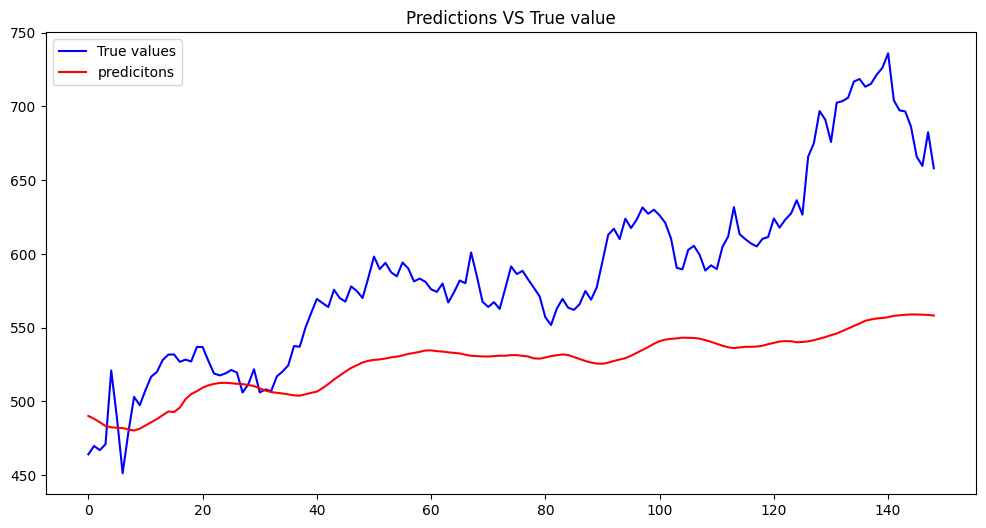

Train MAE: 0.0168, Train MSE: 0.0005


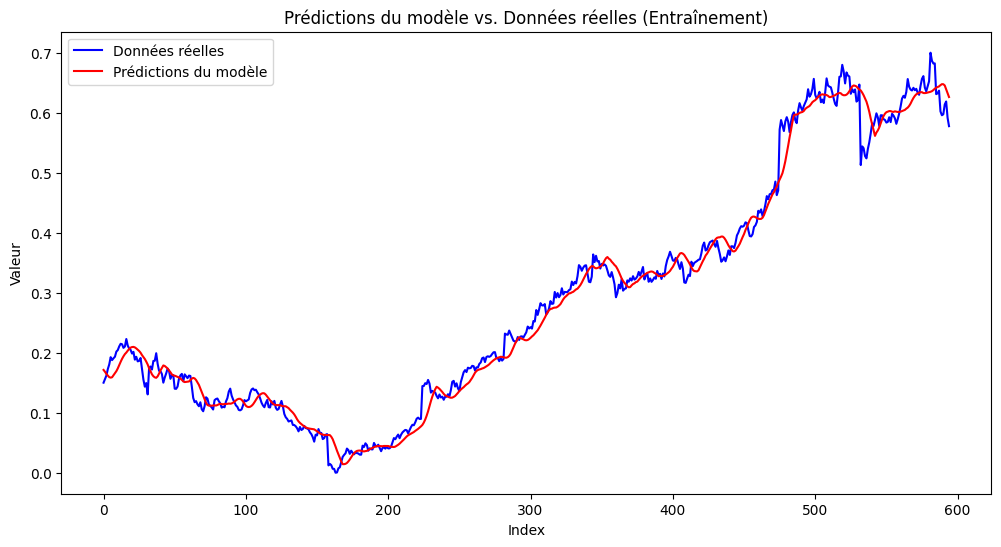

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to("cpu")
        preds = model(batch_X)
        predictions.extend(preds.numpy())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

mae = mean_absolute_error(y_test_real, predictions)
mse = mean_squared_error(y_test_real, predictions)
print(f" mae: {mae}, mse: {mse}")

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="True values", color='blue')
plt.plot(predictions, label="predicitons", color='red')
plt.title('Predictions VS True value')
plt.legend()
plt.show()
